In [ ]:
!pip install torchvision ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip install diffusers transformers einops accelerate

In [2]:
import torch
from google.colab import drive
from torch import nn
from torchvision import datasets, transforms
import numpy as np
from PIL import Image
import torch.nn.functional as F
from torch.utils.data import Dataset
import random
from diffusers import AutoencoderKL
from torchvision.utils import make_grid
import torchvision.utils as vutils
from tqdm.auto import tqdm
from typing import Callable
import os
import pandas as pd
from typing import Tuple, List
import clip
from torchvision.transforms import ToPILImage
from tqdm import trange
import torch.optim as optim
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import Subset

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# Import  data
Dataset celebA is been used

In [4]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/celeba-dataset


## 1.1 attribute_map
We have transformed the attributes of celebA into a map, making it convenient to obtain the prompt words for clipping.

In [94]:
data_dir = "/kaggle/input/celeba-dataset"
attr_file = "list_attr_celeba.csv"
attr_path = f"{data_dir}/{attr_file}"

df = pd.read_csv(attr_path)
attr_names = df.columns.tolist()[1:]


special_fix = {
    "5 o clock shadow": "5 o'clock shadow",
    "blond hair": "blonde hair"
}
attribute_map = {
    idx: (None, special_fix.get(name.replace("_", " ").lower(), name.replace("_", " ").lower()))
    for idx, name in enumerate(attr_names)
}

TARGET_ATTRS = {1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39}
def build_prompt_batch(attr_batch: torch.Tensor) -> list[str]:
    assert attr_batch.dim() == 2 and attr_batch.size(1) == 40
    prompts = []
    arr = attr_batch.cpu().numpy()
    for vec in arr:
        str1 = "a clear, distinctly featured real human"
        phrases = [
            attribute_map[idx][1]
            for idx in TARGET_ATTRS
            if vec[idx] == 1
        ]
        if phrases:
            prompt = f"{str1} with " + ", ".join(phrases)
        else:
            prompt = str1
        prompts.append(prompt)
    return prompts

def get_single_prompt(attr: torch.Tensor) -> str:
    vec = attr.cpu().numpy() if attr.dim() == 1 else attr.squeeze(0).cpu().numpy()
    str1 = "a clear, distinctly featured real human"

    phrases = []
    for idx in TARGET_ATTRS:
        text = attribute_map[idx][1]
        if vec[idx] == 1 and text:
            phrases.append(text)
    if phrases:
        return f"{str1} with " + ", ".join(phrases)
    return str1

## 1.2 dataset

In [7]:
class CelebADataset(Dataset):
    def __init__(self, root_dir, attr_file="list_attr_celeba.csv", transform=None):
        self.img_dir = os.path.join(root_dir, "img_align_celeba", "img_align_celeba")
        self.attr_path = os.path.join(root_dir, attr_file)
        self.transform = transform
        df = pd.read_csv(self.attr_path)
        df = df.replace(-1, 0) #to one hot

        self.image_names = df["image_id"].tolist()
        self.attrs = df.drop(columns=["image_id"]).astype("float32").values  #numpy array

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        attr = self.attrs[idx]  # shape: [40]
        return image, attr

data_dir = "/kaggle/input/celeba-dataset"
attr_file = "list_attr_celeba.csv"
transform = transforms.Compose([
    transforms.CenterCrop(178),
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

dataset = CelebADataset("/kaggle/input/celeba-dataset", transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=2)



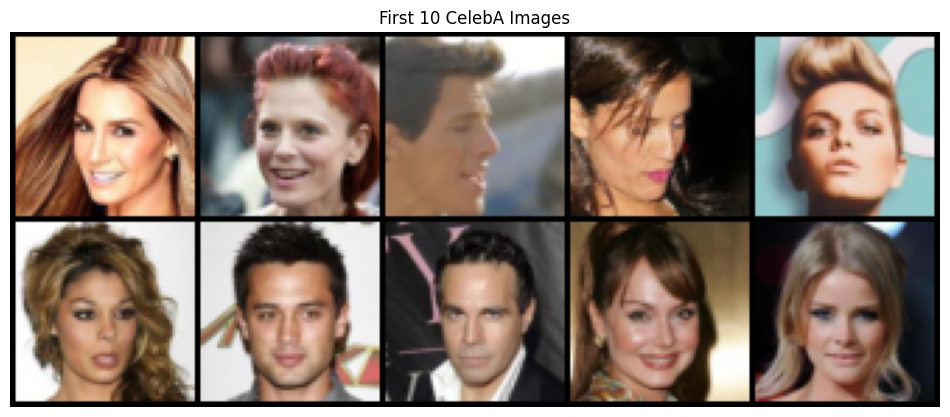

In [8]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

images = [dataset[i][0] for i in range(10)]
grid = vutils.make_grid(images, nrow=5, normalize=True)

plt.figure(figsize=(12, 6))
plt.axis("off")
plt.title("First 10 CelebA Images")
plt.imshow(grid.permute(1, 2, 0))
plt.show()


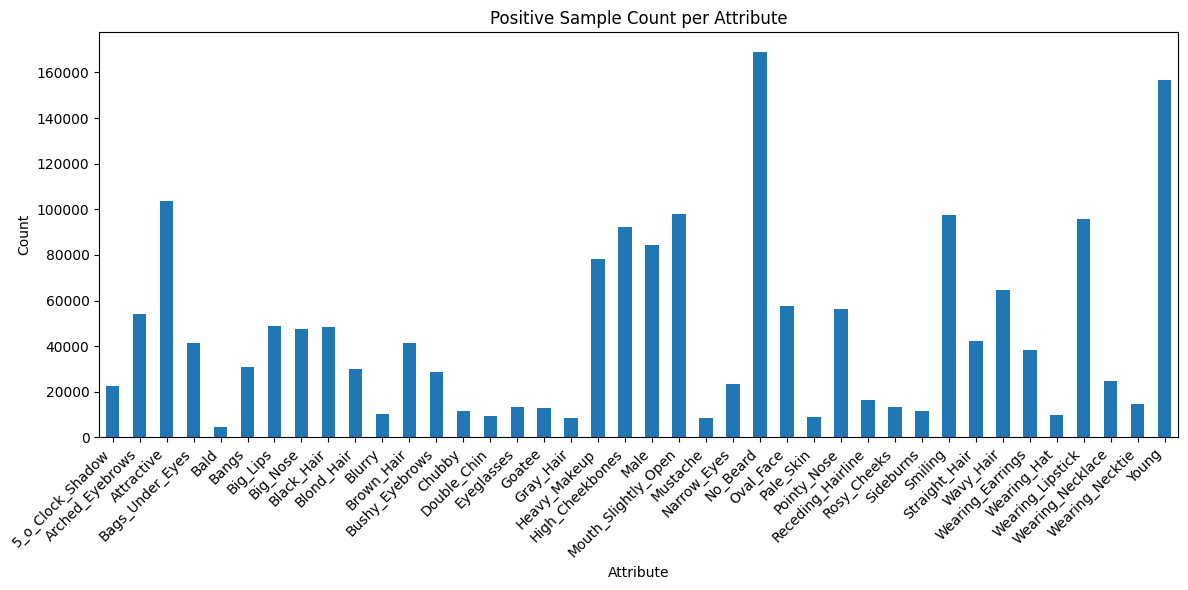

In [9]:
#Exploration of the dataset
df = pd.read_csv(attr_path)
attr_names = df.columns[1:]

stats = {}
for attr in attr_names:
    counts = df[attr].value_counts()  #{-1: x, 1: y}
    neg = counts.get(-1, 0)
    pos = counts.get(1, 0)
    stats[attr] = {"positive": pos, "negative": neg}

stats_df = pd.DataFrame(stats).T
plt.figure(figsize=(12, 6))
stats_df["positive"].plot(kind="bar")
plt.title("Positive Sample Count per Attribute")
plt.xlabel("Attribute")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

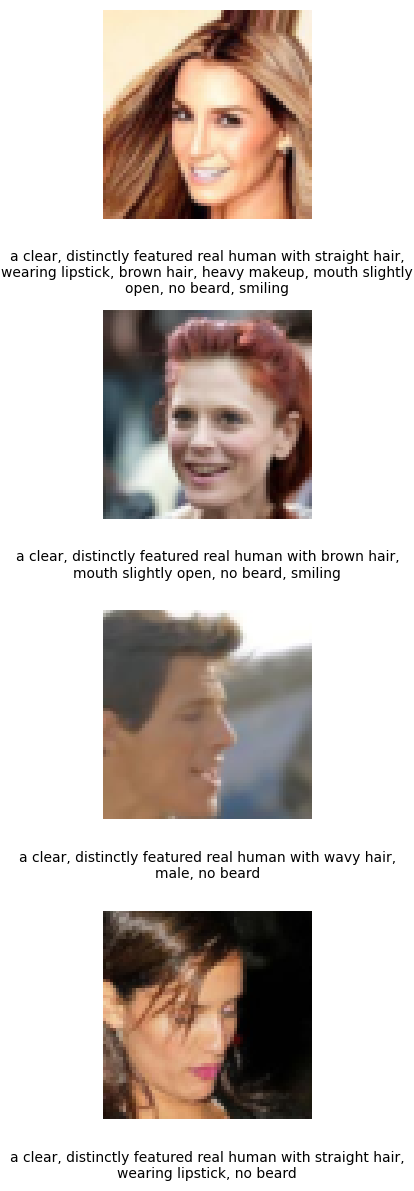

In [10]:
# Show some pictures.
imgs, attrs = next(iter(dataloader))  # [10, 3, 64, 64], [10, 40]

def show_images_individually_top4(imgs, prompts):
    imgs_vis = (imgs + 1) / 2  # [-1,1] → [0,1]
    B = min(4, imgs_vis.shape[0])

    plt.figure(figsize=(4, B * 3))
    for i in range(B):
        plt.subplot(B, 1, i + 1)
        img = imgs_vis[i].permute(1, 2, 0).cpu().numpy()
        plt.imshow(img)
        plt.axis("off")
        plt.text(
            0.5, -0.15, prompts[i],
            fontsize=10,
            ha='center',
            va='top',
            transform=plt.gca().transAxes,
            wrap=True
        )
    plt.tight_layout()
    plt.show()

imgs, attrs = next(iter(dataloader))         # imgs: [B, 3, 64, 64]
prompts = build_prompt_batch(attrs)          # prompts
show_images_individually_top4(imgs, prompts)

# 2.model

## 2.1 Clip

In [11]:
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

100%|███████████████████████████████████████| 338M/338M [00:46<00:00, 7.59MiB/s]


In [12]:
#get feature by Clip
def get_text_features(texts):
    tokens = clip.tokenize(texts).to(device)
    with torch.no_grad():
        text_features = clip_model.encode_text(tokens)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    return text_features.float()

def get_image_feat(batch_imgs):
    with torch.no_grad():
        clip_inputs = torch.stack([clip_preprocess(transforms.ToPILImage()(img.cpu())) for img in batch_imgs])
        clip_inputs = clip_inputs.to(device)
        img_feats = clip_model.encode_image(clip_inputs)
        img_feats = img_feats / img_feats.norm(dim=-1, keepdim=True)
    return img_feats.float()

## 2.2 ConvVAE

In [135]:
class ConvCVAE(nn.Module):
    def __init__(self, img_channels=3, txt_dim=512, attr_dim=0, latent_dim=128, img_size=64, use_attr=False):
        super().__init__()
        self.img_channels = img_channels
        self.txt_dim = txt_dim #512
        self.attr_dim = attr_dim #40
        self.latent_dim = latent_dim #128
        self.img_size = img_size #128
        self.use_attr = use_attr
        self.cond_dim = txt_dim + (attr_dim if use_attr else 0)

        #Encoder
        self.enc = nn.Sequential(
            nn.Conv2d(img_channels + self.cond_dim, 32, 4, 2, 1),  # 32x32
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),  # 16x16
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),  # 8x8
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1),
        )

        with torch.no_grad():
            dummy = torch.zeros(1, img_channels + self.cond_dim, img_size, img_size)
            h = self.enc(dummy)
            self.flatten_dim = h.view(1, -1).shape[1]

        self.fc_mu = nn.Linear(self.flatten_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_dim, latent_dim)
        self.decoder_input = nn.Linear(latent_dim + self.cond_dim, self.flatten_dim)

        #Decoder
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),   # 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),    # 64x64
            nn.ReLU(),
            nn.ConvTranspose2d(32, img_channels, 4, 2, 1),
            nn.Tanh()
        )

    def encode(self, x, txt_feat, attr_feat=None):
        cond_feat = txt_feat
        if self.use_attr and attr_feat is not None:
            cond_feat = torch.cat([txt_feat, attr_feat], dim=1)  # [B,txt+attr]

        cond = cond_feat.unsqueeze(-1).unsqueeze(-1).expand(-1, -1, x.shape[2], x.shape[3])
        x_cat = torch.cat([x, cond], dim=1)
        h = self.enc(x_cat)
        h_flat = h.view(h.size(0), -1)
        mu = self.fc_mu(h_flat)
        logvar = self.fc_logvar(h_flat)
        return mu, logvar

    def decode(self, z, txt_feat, attr_feat=None):
        cond_feat = txt_feat
        if self.use_attr and attr_feat is not None:
            cond_feat = torch.cat([txt_feat, attr_feat], dim=1)
        z_cat = torch.cat([z, cond_feat], dim=1)
        h = self.decoder_input(z_cat).view(-1, 256, 4, 4)
        x_rec = self.dec(h)
        return x_rec

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, txt_feat, attr_feat=None):
        mu, logvar = self.encode(x, txt_feat, attr_feat)
        z = self.reparameterize(mu, logvar)
        x_rec = self.decode(z, txt_feat, attr_feat)
        return x_rec, mu, logvar

## 2.3 Train

In [136]:
def train(model, dataloader, epochs=10, lr=1e-3, beta=1.0):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    loss_history = []
    for epoch in range(epochs):
        total_loss = 0
        loop = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")
        for imgs, attrs in loop:
            imgs = imgs.to(device)
            batch_size = imgs.shape[0]
            prompts = build_prompt_batch(attrs)

            #prompts  ["A real human face"] *batch_size
            txt_feats = get_text_features(prompts)
            #img_feats=get_image_feat(imgs, device)
            img_feats =attrs.to(device).float()
            x_rec, mu, logvar = model(imgs, txt_feats,img_feats)
            #x_rec, mu, logvar = model(imgs, txt_feats)

            recon_loss = F.mse_loss(x_rec, imgs)
            kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
            loss = recon_loss + kl_loss * beta

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            loop.set_postfix({
                "loss": loss.item(),
                "recon": recon_loss.item(),
                "kl": kl_loss.item()
            })
        avg_loss = total_loss / len(dataloader)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1}, Avg Loss: {total_loss/len(dataloader):.4f}")
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, epochs + 1), loss_history, marker='o')
    plt.title("Training Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [133]:
#model = ConvCVAE(img_channels=3, latent_dim=128, txt_dim=512).to(device)

# We didn't use the attr one-hot, use clip emmbeding only
model =  ConvCVAE(txt_dim=512, attr_dim=40, use_attr=False).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [137]:
#for saving time use smaller dataloader
subset_size = 5000
indices = random.sample(range(len(dataset)), subset_size)
small_dataset = Subset(dataset, indices)
small_loader = DataLoader(small_dataset, batch_size=32, shuffle=True, num_workers=0)

print("sample num：", len(small_dataset))
img, attr = small_dataset[0]
print("img shape：", img.shape)
print("attr shape：", attr.shape)

sample num： 5000
img shape： torch.Size([3, 64, 64])
attr shape： (40,)


In [ ]:
model.train()
train(model=model, dataloader=small_loader, epochs=20,beta=0.7)

#  3.Edit

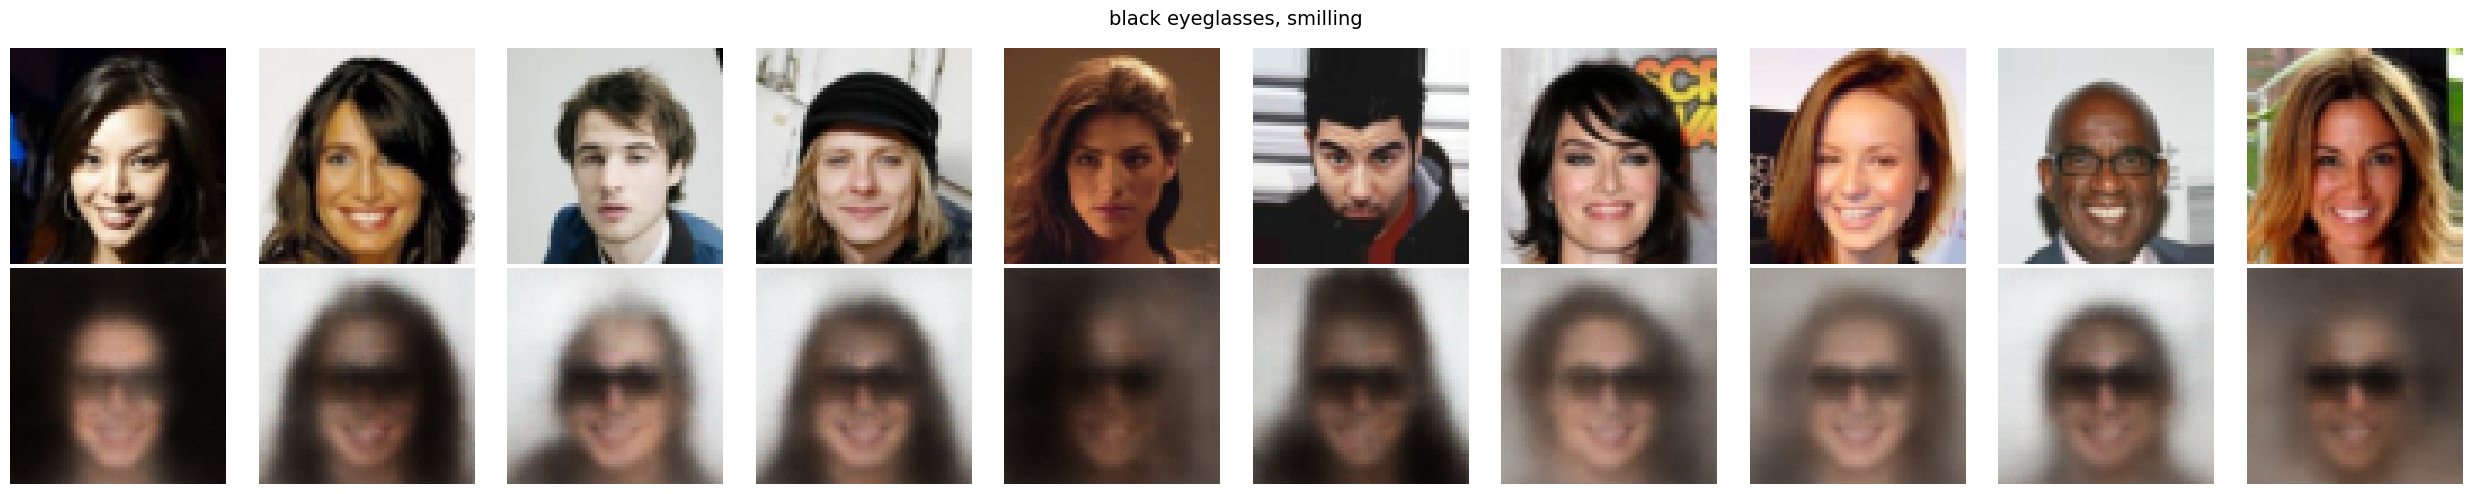

In [154]:
model.eval()
with torch.no_grad():
    imgs, attrs= next(iter(small_loader))
    imgs = imgs[:10].to(device)
    attr_labels = attrs[:10].to(device).float()
edit='black eyeglasses, smilling'
edit_prompts = [""+edit] *10

# get text feature
txt_feat = get_text_features(edit_prompts)
# forward propagate
x_rec, mu, logvar = model(imgs, txt_feat, attr_labels)

#show image
def show_individual_comparison(orig_imgs, gen_imgs, prompts):
    orig_imgs = (orig_imgs + 1) / 2
    gen_imgs  = (gen_imgs + 1) / 2

    n = orig_imgs.size(0)
    fig, axes = plt.subplots(2, n, figsize=(2.5*n, 5))

    for i in range(n):
        #ori
        axes[0, i].imshow(to_pil_image(orig_imgs[i].cpu()))
        axes[0, i].axis("off")
        #edited
        axes[1, i].imshow(to_pil_image(gen_imgs[i].cpu()))
        axes[1, i].axis("off")

    axes[0, 0].set_ylabel("Original", fontsize=10)
    axes[1, 0].set_ylabel("Edited", fontsize=10)
    plt.suptitle(edit, fontsize=14)
    plt.tight_layout()
    plt.show()

show_individual_comparison(imgs, x_rec, edit_prompts)

# 4.Evaluation

In [161]:
model.eval()
with torch.no_grad():
    all_imgs = []
    all_attrs = []
    for batch_imgs, batch_attrs in small_loader:
        all_imgs.append(batch_imgs)
        all_attrs.append(batch_attrs)
        if sum([x.size(0) for x in all_imgs]) >= 100:
            break

    imgs = torch.cat(all_imgs, dim=0)[:100].to(device)
    attr_labels = torch.cat(all_attrs, dim=0)[:100].to(device).float()

    edit_prompt = "black eyeglasses, smiling"
    edit_prompts = [edit_prompt] * 100
    txt_feat = get_text_features(edit_prompts)  # [100, 512]

    # Generate images through reasoning
    x_rec, _, _ = model(imgs, txt_feat, attr_labels)

    # Obtain the CLIP image features
    orig_feats = get_image_feat(imgs)
    edit_feats = get_image_feat(x_rec)
    text_feats = get_text_features(edit_prompts)

    # Calculate similarity
    sim_orig = (orig_feats * text_feats).sum(dim=1)
    sim_edit = (edit_feats * text_feats).sum(dim=1)
    sim_gain = sim_edit - sim_orig

    for i in range(len(sim_orig)):
        print(f"[{i}] Prompt: {edit_prompts[i]}")
        print(f"Original similarity: {sim_orig[i]:.4f}")
        print(f"Edited similarity  : {sim_edit[i]:.4f}")
        print(f"Gain               : {sim_gain[i]:.4f}")
        print("-" * 30)

[0] Prompt: black eyeglasses, smiling
Original similarity: 0.2218
Edited similarity  : 0.2344
Gain               : 0.0127
------------------------------
[1] Prompt: black eyeglasses, smiling
Original similarity: 0.1971
Edited similarity  : 0.2106
Gain               : 0.0135
------------------------------
[2] Prompt: black eyeglasses, smiling
Original similarity: 0.2066
Edited similarity  : 0.2118
Gain               : 0.0052
------------------------------
[3] Prompt: black eyeglasses, smiling
Original similarity: 0.2324
Edited similarity  : 0.2005
Gain               : -0.0319
------------------------------
[4] Prompt: black eyeglasses, smiling
Original similarity: 0.2350
Edited similarity  : 0.2484
Gain               : 0.0135
------------------------------
[5] Prompt: black eyeglasses, smiling
Original similarity: 0.2057
Edited similarity  : 0.2191
Gain               : 0.0134
------------------------------
[6] Prompt: black eyeglasses, smiling
Original similarity: 0.1983
Edited similari

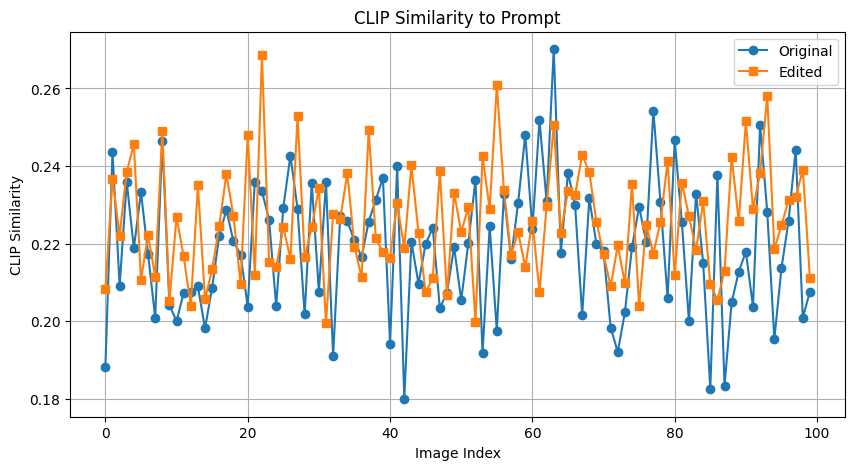

In [160]:
plt.figure(figsize=(10, 5))
plt.plot(sim_orig.cpu(), label="Original", marker='o')
plt.plot(sim_edit.cpu(), label="Edited", marker='s')
plt.xlabel("Image Index")
plt.ylabel("CLIP Similarity")
plt.title("CLIP Similarity to Prompt")
plt.legend()
plt.grid(True)
plt.show()

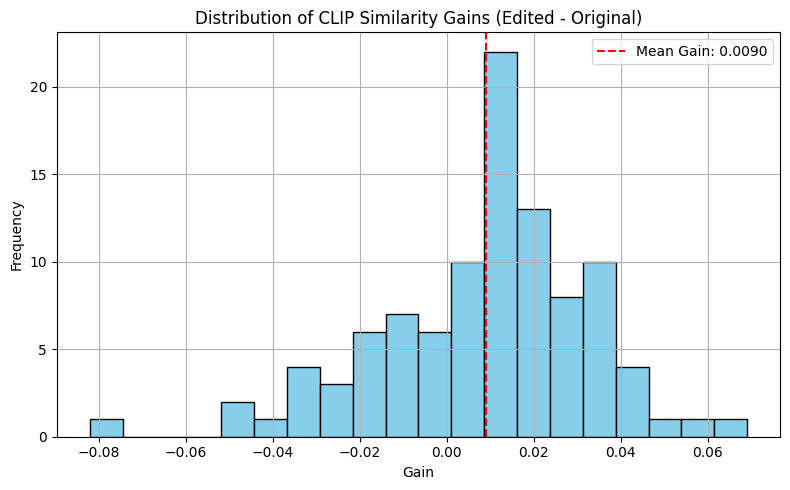

In [163]:
plt.figure(figsize=(8, 5))
plt.hist(sim_gain.cpu().numpy(), bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of CLIP Similarity Gains (Edited - Original)")
plt.xlabel("Gain")
plt.ylabel("Frequency")
plt.axvline(sim_gain.mean().item(), color='red', linestyle='--', label=f"Mean Gain: {sim_gain.mean().item():.4f}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#  5.Save model

## 5.1 save model

In [40]:
drive.mount('/content/drive')

save_path = '/content/drive/MyDrive/celeba/conv_vae_512_64.pth'
torch.save(model.state_dict(), save_path)
print(f' save at {save_path}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 save at /content/drive/MyDrive/celeba/conv_vae_512_64.pth


## 5.2 load model

In [82]:
drive.mount('/content/drive')
load_path = '/content/drive/MyDrive/celeba/conv_vae_512_64.pth'
model.load_state_dict(torch.load(load_path, map_location=device))
model.eval()

print("load.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
load.


## 5.3 load data
For any possible issues that may arise, we have prepared a backup dataset.

In [ ]:
drive.mount('/content/drive')
!mkdir -p ./data/celeba
!unzip -q "/content/drive/MyDrive/img_align_celeba.zip" -d ./data/celeba/

In [ ]:
!cp "/content/drive/MyDrive/celeba/list_attr_celeba.txt" ./data/celeba/
!cp "/content/drive/MyDrive/celeba/list_eval_partition.txt" ./data/celeba/
!cp "/content/drive/MyDrive/celeba/identity_CelebA.txt" ./data/celeba/
!cp "/content/drive/MyDrive/celeba/list_bbox_celeba.txt" ./data/celeba/
!cp "/content/drive/MyDrive/celeba/list_landmarks_celeba.txt" ./data/celeba/
!cp "/content/drive/MyDrive/celeba/list_landmarks_align_celeba.txt" ./data/celeba/

cp: cannot stat '/content/drive/MyDrive/celeba/list_attr_celeba.txt': No such file or directory
cp: cannot stat '/content/drive/MyDrive/celeba/list_eval_partition.txt': No such file or directory
cp: cannot stat '/content/drive/MyDrive/celeba/identity_CelebA.txt': No such file or directory
cp: cannot stat '/content/drive/MyDrive/celeba/list_bbox_celeba.txt': No such file or directory
cp: cannot stat '/content/drive/MyDrive/celeba/list_landmarks_celeba.txt': No such file or directory
cp: cannot stat '/content/drive/MyDrive/celeba/list_landmarks_align_celeba.txt': No such file or directory


In [ ]:
import os
print(os.listdir('./data/celeba'))
print(os.listdir('./data/celeba/img_align_celeba')[:5])

['list_eval_partition.txt', 'list_attr_celeba.txt', 'list_bbox_celeba.txt', 'img_align_celeba', 'list_landmarks_celeba.txt', 'identity_CelebA.txt', 'list_landmarks_align_celeba.txt']
['069584.jpg', '126787.jpg', '145990.jpg', '050305.jpg', '113968.jpg']
